In [1]:
import pyproj
from  pyproj  import  CRS
from pyproj import Proj
import h5py
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
import glob
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset

In [19]:
"读取单个h5文件并可视化,最后图像为一条轨道上的数据"

dir_path = '.\H2B_nc_data\ICESAT2_ATL12_20200711'
ncfiles = glob.glob(dir_path + '\*.h5')
lon_array = np.array([])

lat_array = np.array([])
swh_array = np.array([])
for ncfile in ncfiles:
    with h5py.File(ncfile, 'r') as f:
        lats = f['gt2l']['ssh_segments']['latitude'][:]
        lons = f['gt2l']['ssh_segments']['longitude'][:]
        swh = f['gt2l']['ssh_segments']['heights']['swh'][:]
    lon_array = np.append(lon_array, lons)
    lat_array = np.append(lat_array, lats)
    swh_array = np.append(swh_array, swh)


In [20]:
for i in range(len(lon_array)):
    if lon_array[i]<0:
        lon_array[i] += 360


In [23]:
lon_array.max()

359.9975963387237

In [24]:
# 将WGS 84坐标（4326）转化为等距圆柱投影（4088）
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")

transformer = pyproj.Transformer.from_crs(crs,crs2)
projlats,projlons = transformer.transform(lat_array,lon_array)

In [25]:
# 设置空间分辨率
resolution = 5000
# pb_lat_max, pb_lat_min, pb_lon_max, pb_lon_min = 20003989.28 , -20003989.28, 9451579.15, -9451579.15
# nlat, nlon = np.int((pb_lat_max-pb_lat_min ) / resolution), np.int((pb_lon_max - pb_lon_min) / resolution)
nlat, nlon =(projlats.max()-projlats.min())/resolution, (projlons.max() - projlons.min())/resolution
nlat = np.int(nlat)
nlon = np.int(nlon)
swh_grid = np.full(shape=(nlon,nlat), fill_value=np.nan)
swh_grid_num = np.zeros((nlon,nlat))

In [26]:
swh_grid.shape

(6915, 7616)

In [27]:
# 填充每个点的数值，将有重复数据的点标记到swh_grid_num中,最后求平均
for i in range(len(swh_array)):
    x = int((projlons[i] )/resolution)
    y = int(projlats[i]/resolution)
    if x >= 0:
        if swh_grid_num[x][y] == 0:
            swh_grid[x][y] = swh_array[i]
            swh_grid_num[x][y] += 1
        else:
            swh_grid[x][y] += swh_array[i]
            swh_grid_num[x][y] += 1
    else:
        x_fix = x + nlon
        if swh_grid_num[x_fix][y] == 0:
            swh_grid[x_fix][y] = swh_array[i]
            swh_grid_num[x_fix][y] += 1
        else:
            swh_grid[x_fix][y] += swh_array[i]
            swh_grid_num[x_fix][y] += 1
swh_grid = swh_grid / swh_grid_num

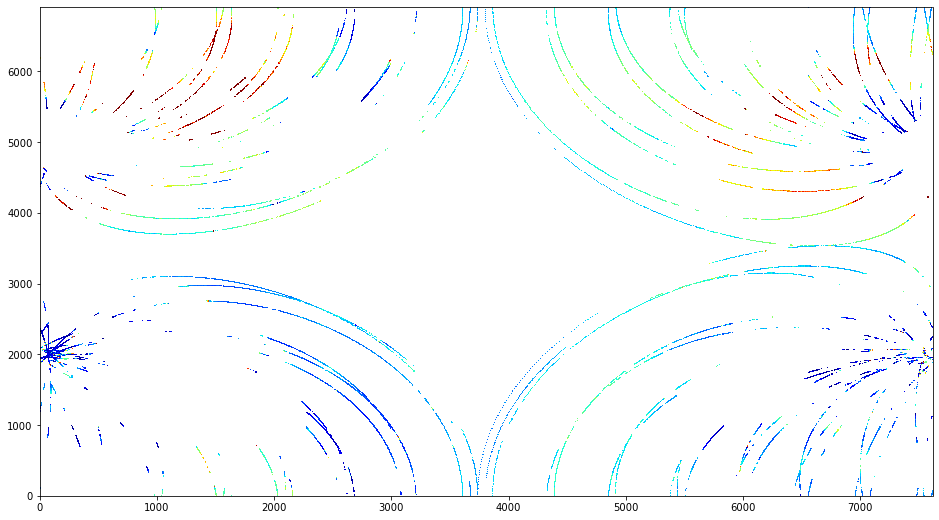

In [28]:
plt.figure(figsize=(16,9))
plt.pcolor(swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
plt.show()
plt.close()

In [29]:
# 校准y坐标
x = np.arange(nlat)
y = np.arange(nlon)
xx , yy = np.meshgrid(x * resolution, y * resolution)

# 将xx,yy转换回坐标形式
transformer_back = pyproj.Transformer.from_crs(crs2,crs)
y_map, x_map = transformer_back.transform(xx , yy)


In [59]:
a,b = transformer_back.transform(3300*resolution , 50*resolution)

In [60]:
print(a,b)

0.4519845072420791 148.2419416963983


In [34]:
x_map.min()

-179.9999994838951

In [30]:
'''for i in range(x_map.shape[0]):
    for j in range(x_map.shape[1]):
        if x_map[i, j] < 0 :
            x_map[i, j] += 360'''

'for i in range(x_map.shape[0]):\n    for j in range(x_map.shape[1]):\n        if x_map[i, j] < 0 :\n            x_map[i, j] += 360'

<ipython-input-31-0d49a4b7b7d1>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_map, y_map, swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)


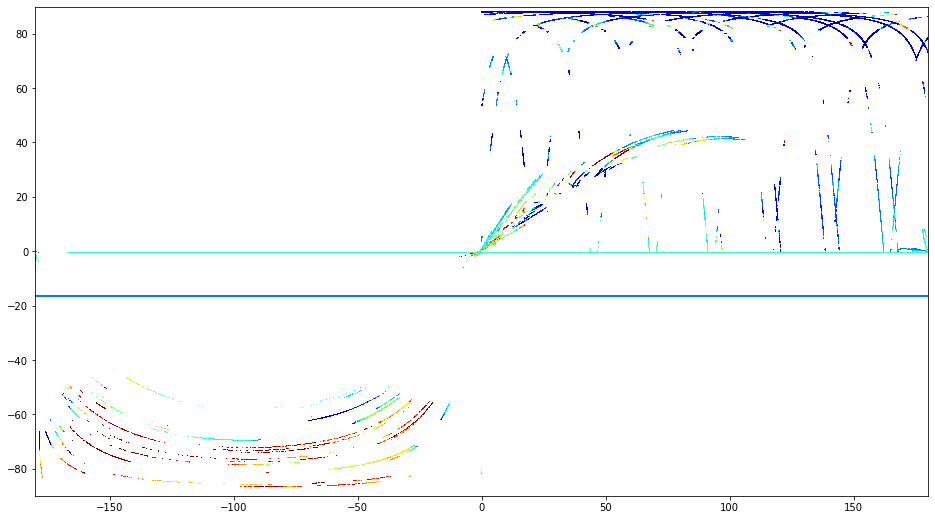

In [31]:
plt.figure(1,figsize=(16,9))
plt.pcolor(x_map, y_map, swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
plt.show()

<ipython-input-32-c886fbc87c64>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = m.pcolor(xi , yi, data=swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)


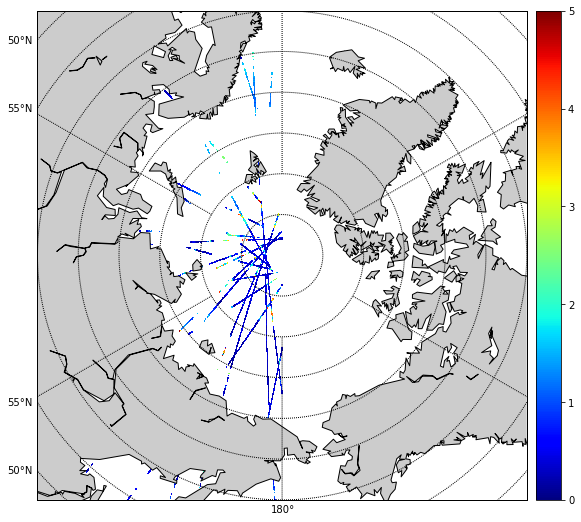

In [32]:
plt.figure(2,figsize=(16, 9))
# m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
xi, yi = m(x_map, y_map)

# Draw the scatterplot
h = m.pcolor(xi , yi, data=swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.show(2)
plt.close()

# 2.HY-2B有效波高显示

In [69]:

hy_dir_path = 'E:\python_workfile\\remote_sensing\H2B_nc_data\H2B_20200711'
hyfiles = glob.glob(hy_dir_path + '\*.nc')
hy_lon_array = np.array([])
hy_lat_array = np.array([])
hy_swh_array = np.array([])
hy_swhc_mask_array = np.array([])
for hyfile in hyfiles:
    fh = Dataset(hyfile, mode='r')
    lons = fh.variables['lon'][:]
    lats = fh.variables['lat'][:]
    swhc = fh.variables['swh_c'][:]
    swhc_mask = swhc.mask
    hy_lon_array = np.append(hy_lon_array, lons)
    hy_lat_array = np.append(hy_lat_array, lats)
    hy_swh_array = np.append(hy_swh_array, swhc)
    hy_swhc_mask_array = np.append(hy_swhc_mask_array, swhc_mask)
    fh.close()
hy_swhc_array_masked = np.ma.array(hy_swh_array, mask=hy_swhc_mask_array)


In [70]:
transformer = pyproj.Transformer.from_crs(crs,crs2)
hy_projlats,hy_projlons = transformer.transform(hy_lat_array,hy_lon_array)

In [71]:
# 设置空间分辨率
resolution = 5000
hy_nlat, hy_nlon =(hy_projlats.max()-hy_projlats.min())/resolution, (hy_projlons.max() - hy_projlons.min())/resolution
hy_nlat = np.int(hy_nlat)
hy_nlon = np.int(hy_nlon)
hy_swh_grid = np.full(shape=(hy_nlon,hy_nlat), fill_value=np.nan)

hy_swh_grid_num = np.zeros((hy_nlon,hy_nlat))

In [72]:
# 填充每个点的数值，将有重复数据的点标记到swh_grid_num中,最后求平均
for i in range(len(hy_swhc_array_masked)):
    x = int(hy_projlons[i]/resolution)
    y = int(hy_projlats[i]/resolution)
    
    if hy_swh_grid_num[x][y] == 0:
        hy_swh_grid[x][y] = hy_swhc_array_masked[i]
        hy_swh_grid_num[x][y] += 1
    else:
        hy_swh_grid[x][y] += hy_swhc_array_masked[i]
        hy_swh_grid_num[x][y] += 1
hy_swh_grid = hy_swh_grid / hy_swh_grid_num

<ipython-input-72-aa1d0875df3b>:7: UserWarning: Warning: converting a masked element to nan.
  hy_swh_grid[x][y] = hy_swhc_array_masked[i]
<ipython-input-72-aa1d0875df3b>:10: UserWarning: Warning: converting a masked element to nan.
  hy_swh_grid[x][y] += hy_swhc_array_masked[i]


In [73]:
'''n = np.int(projlats.max() / resolution /2)
temp = np.array(hy_swh_grid[:n])
hy_swh_grid[0:hy_swh_grid.shape[0]-n] = hy_swh_grid[n:]
hy_swh_grid[hy_swh_grid.shape[0]-n:] = temp'''

'n = np.int(projlats.max() / resolution /2)\ntemp = np.array(hy_swh_grid[:n])\nhy_swh_grid[0:hy_swh_grid.shape[0]-n] = hy_swh_grid[n:]\nhy_swh_grid[hy_swh_grid.shape[0]-n:] = temp'

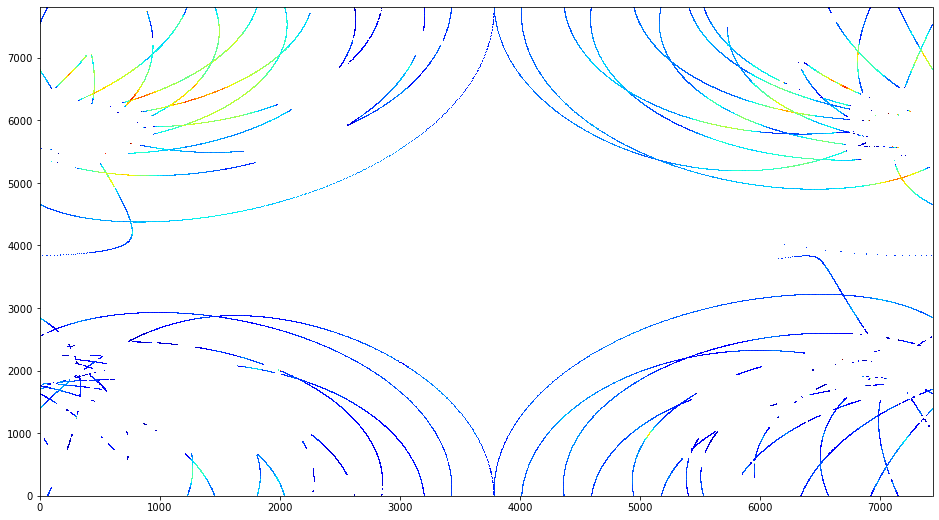

In [74]:
plt.figure(figsize=(16,9))
plt.pcolor(hy_swh_grid, cmap=plt.cm.jet,vmin=0, vmax=10)
plt.show()
plt.close()

In [75]:
# 校准y坐标
hy_x = np.arange(hy_nlat)
hy_y = np.arange(hy_nlon) 
hy_xx , hy_yy = np.meshgrid(hy_x * resolution, hy_y * resolution)

# 将xx,yy转换回坐标形式
transformer_back = pyproj.Transformer.from_crs(crs2,crs)
hy_y_map, hy_x_map = transformer_back.transform(hy_xx , hy_yy)

<ipython-input-76-3570b633a330>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(hy_x_map, hy_y_map, hy_swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)


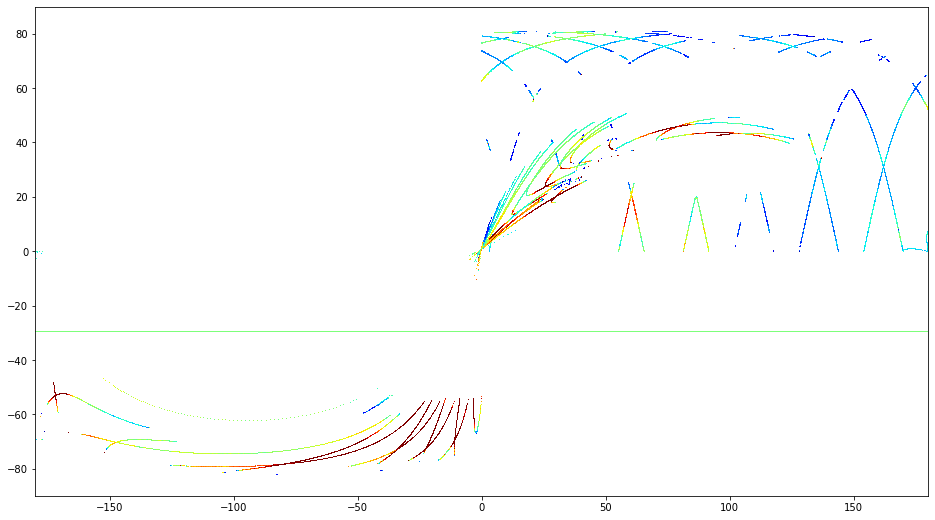

In [76]:
plt.figure(1,figsize=(16,9))
plt.pcolor(hy_x_map, hy_y_map, hy_swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
plt.show()

<ipython-input-78-b77195a83987>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)


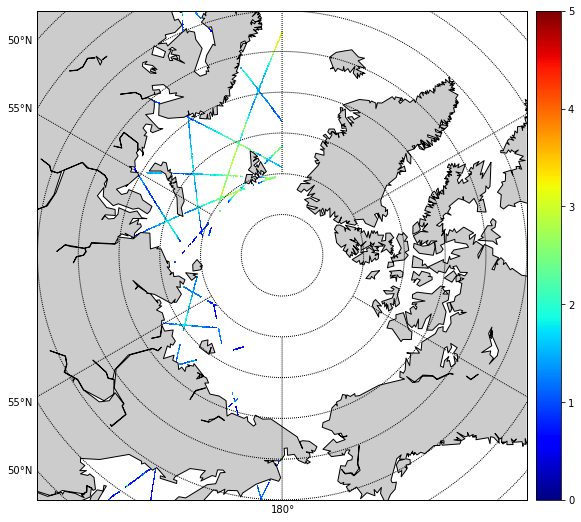

In [78]:
plt.figure(1,figsize=(16, 9))
# hy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
hy_m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
hy_xi, hy_yi = hy_m(hy_x_map, hy_y_map)

# Draw the scatterplot
h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_swh_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
hy_m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

hy_m.drawcoastlines()
hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.show(1)